In [1]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = '3_neural_net.ipynb'
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
import timm
from timm.optim import NovoGrad
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import wandb

from sklearn.pipeline import make_pipeline, make_union
from src.constants import TARGETS
seed = 4578690
pl.seed_everything(seed)

Global seed set to 4578690


4578690

In [2]:
class RandomData(Dataset):
    def __init__(self, data, labels, scaler):
        super().__init__()
        self.data = data.copy()
        self.data[np.isnan(self.data)] = 0
        self.data = scaler.transform(self.data)
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return self.data[idx].astype(np.float32), np.sqrt(self.labels[idx]).astype(np.float32)/10.0


class FCModel(nn.Module):
    def __init__(self, in_f, out_f, d, p):
        super().__init__()
        self.fc1 = nn.Linear(in_f, d)
        self.h1 = nn.Linear(d, d)
        self.classifier = nn.Linear(d, 4)
        self.bnorm1 = nn.BatchNorm1d(in_f)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.bnorm2 = nn.BatchNorm1d(d)
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.bnorm1(x)
        x = self.fc1(self.drop(x))
        x = self.relu(x)
        x = x + x * self.tanh(self.h1(x))
        #x = self.bnorm2(x)
        x = self.relu(x)
        x = self.classifier(self.drop(x))
        return x

class LitModel(pl.LightningModule):
    """PL Model"""
    def __init__(
        self,
        in_f=503,
        out_f=4,
        d=196,
        p=0.05,
        lr=0.003,
        wd=0.001,
        grad_avg=True,
        steps=[30],
        gamma=0.1,
        
    ):
        super().__init__()
        self.save_hyperparameters()
        self.model = FCModel(in_f, out_f, d, p)
        self.criterion = torch.nn.L1Loss()

    def forward(self, x):
        return self.model(x)

    def step(self, batch):
        x, y = batch
        yhat = self.forward(x)
        loss = self.criterion(yhat, y)
        return loss, torch.square(10*yhat), torch.square(10*y)

    def training_step(self, batch, batch_idx):
        loss, preds, y = self.step(batch)
        loss_corr = self.criterion(y, preds)
        self.log("train/loss", loss_corr, on_step=True, on_epoch=True, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        loss, preds, y = self.step(batch)
        loss_corr = self.criterion(y, preds)

        self.log("val/loss", loss_corr, on_step=False, on_epoch=True, prog_bar=True)
        return {"loss": loss}

    def test_step(self, batch, batch_idx):
        loss, preds, y = self.step(batch)
        return {"loss": loss, "preds": preds}

    def test_epoch_end(self, outputs):
        preds = torch.cat([o["preds"] for o in outputs], 0).cpu().numpy()
        self.log("output", preds)

    def configure_optimizers(self):
        optimizer = NovoGrad(self.parameters(), grad_averaging=self.hparams.grad_avg, lr=self.hparams.lr, weight_decay=self.hparams.wd)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, gamma=self.hparams.gamma, milestones=self.hparams.steps)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

In [3]:
tr_index, vl_index = pd.read_csv("data/tr_index_small.csv"), pd.read_csv("data/vl_index_small.csv")
tr_index.shape, vl_index.shape

((1424400, 6), (18992, 6))

In [4]:
X_tr, X_vl = np.load("data/X_tr1_v1.npy"), np.load("data/X_vl1_v1.npy")

In [5]:
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_tr_cats = onehot.fit_transform(X_tr[:, [14, 15]])

X_tr1 = np.hstack((X_tr_cats, X_tr[:, np.r_[0:14, 16:379]]))
X_vl_cats = onehot.transform(X_vl[:, [14, 15]])

X_vl1 = np.hstack((X_vl_cats, X_vl[:, np.r_[0:14, 16:379]]))
print(X_tr1.shape, X_vl1.shape)

(1424400, 404) (18992, 404)


In [6]:
joblib.dump(onehot, "artifacts/onehot_v1.pkl")

['artifacts/onehot_v1.pkl']

In [7]:
scaler = MinMaxScaler((-1, 1), clip=True)
scaler.fit(X_tr1)
joblib.dump(scaler, "artifacts/min_max_scaler.pkl")

['artifacts/min_max_scaler.pkl']

In [8]:
tr_labels = tr_index[TARGETS].values
vl_labels = vl_index[TARGETS].values
print(tr_labels.shape, vl_labels.shape)

(1424400, 4) (18992, 4)


In [9]:
#np.where(pd.DataFrame(np.load("data/X_vl1_v1.npy")).isnull().sum(axis=0) < 15000)

In [10]:
BATCH_SIZE = 4096
NUM_WORKERS = 8
IN_F = X_tr1.shape[1]
D = 196
P = 0.04
LR = 0.005
WD = 0.001
GRAD_AVG = True
MAX_EPOCHS = 50
STEPS = [30, 40]
GAMMA = 0.1
version = 'v1'

In [11]:
tr_ds = RandomData(X_tr1, tr_labels, scaler)
tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
vl_ds = RandomData(X_vl1, vl_labels, scaler)
vl_dl = DataLoader(vl_ds, batch_size=BATCH_SIZE*2, drop_last=False, shuffle=False, num_workers=NUM_WORKERS)

In [12]:
model = LitModel(IN_F, 4, D, P, lr=LR, wd=WD, grad_avg=GRAD_AVG, steps=STEPS, gamma=GAMMA)

callbacks = [pl.callbacks.ModelCheckpoint(monitor='val/loss', save_top_k=3, mode='min', dirpath=f'data/checkpoints/{D}_{seed}_{version}', auto_insert_metric_name=False,
                                         filename="epoch={epoch}-val_loss={val/loss:.4f}")]
logger = pl.loggers.wandb.WandbLogger(project='mlb', name=f'nnflat_vl15_{str(D)}_{seed}', tags=['flat nn', f'{D}'], id=wandb.util.generate_id())
logger.log_hyperparams({'D': D, 'P': P, 'LR': LR, 'WD': WD, 'GRAD_AVG': GRAD_AVG, 'BATCH_SIZE': BATCH_SIZE})
trainer = pl.Trainer(gpus=[1], max_epochs=MAX_EPOCHS, logger=logger, callbacks=callbacks, stochastic_weight_avg=False, deterministic=True)

wandb: Currently logged in as: mohsinhkn (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [13]:
trainer.fit(model, tr_dl, vl_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type    | Params
--------------------------------------
0 | model     | FCModel | 119 K 
1 | criterion | L1Loss  | 0     
--------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.480     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 4578690


Training: 0it [00:00, ?it/s]

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/timm/optim/novograd.py:76: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/torch/csrc/utils/python_arg_parser.cpp:1005.)
  p.data.add_(-step_size, m)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [14]:
from pathlib import Path
top_model_files = Path(f"data/checkpoints/{D}_{seed}_{version}").glob("*.ckpt")
top_model_files = sorted(top_model_files, key=lambda x: float(x.stem.split("=")[-1]))[:3]

preds_nn = []
for file in top_model_files:
    model.load_state_dict(torch.load(str(file))["state_dict"], strict=False)
    model.freeze()
    preds = trainer.test(model, vl_dl)[0]['output']
    preds_nn.append(preds)

preds_nn = np.mean(preds_nn, 0)
mae(preds_nn, vl_labels)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'output': array([[2.0344352e-02, 5.4114027e+00, 3.8827900e-02, 9.7253984e-01],
       [3.0357066e-01, 4.8826323e+00, 2.7951223e-01, 4.1130033e+00],
       [8.3179809e-03, 2.9981480e+00, 6.0562151e-03, 9.0728879e-01],
       ...,
       [5.9081514e-05, 4.7101516e-02, 5.9415901e-04, 7.8240335e-02],
       [9.6554393e-03, 1.6377442e+00, 4.8758597e-03, 6.1374992e-01],
       [8.2178478e-04, 6.9628435e-01, 1.4795987e-03, 3.0288061e-01]],
      dtype=float32)}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'output': array([[2.1846611e-02, 5.5904174e+00, 3.2160528e-02, 9.3710870e-01],
       [2.9245180e-01, 4.4601121e+00, 2.7780101e-01, 4.0379829e+00],
       [5.7862964e-03, 2.9797142e+00, 5.4847393e-03, 8.7622857e-01],
       ...,
       [1.2536530e-07, 4.2629946e-02, 1.3947539e-04, 4.7700476e-02],
       [6.8819490e-03, 1.5707207e+00, 2.5488315e-03, 5.1102799e-01],
       [3.8101818e-04, 6.5960884e-01, 8.2423672e-04, 2.4455880e-01]],
      dtype=float32)}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'output': array([[2.1433821e-02, 5.8686676e+00, 3.9454009e-02, 9.9180800e-01],
       [2.9279873e-01, 4.3542242e+00, 2.5084311e-01, 3.7104950e+00],
       [6.1727557e-03, 2.9906769e+00, 6.5113218e-03, 8.9645201e-01],
       ...,
       [4.4587387e-06, 4.7075085e-02, 3.2672490e-04, 6.0530439e-02],
       [6.4131110e-03, 1.6224226e+00, 2.9968563e-03, 5.5533803e-01],
       [6.3960563e-04, 6.6938227e-01, 1.3875967e-03, 2.5881305e-01]],
      dtype=float32)}
--------------------------------------------------------------------------------


1.340572125351303

In [15]:
wandb.finish()

train/loss_step,1.01296
epoch,49
trainer/global_step,17400
_runtime,367
_timestamp,1627384128
_step,450
train/loss_epoch,1.0645
val/loss,1.34619


train/loss_step,▇▆█▄▆▃▇▆▅▃▂▅▇▄▂▃▄▄▂▂▄▃▅▁▄▄▅▂▃▄▄▃▃▁▂▄▂▄▄▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss_epoch,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▅▅▄▅▆▄▄▃▃▃▂▃▂▂▂▄▂▃▄▂▄▆▃▁▁▂▁▂▂▂▁▁▁▁▁▂▂▂▁


In [16]:
print(top_model_files)

[PosixPath('data/checkpoints/196_4578690_v1/epoch=31-val_loss=1.3397.ckpt'), PosixPath('data/checkpoints/196_4578690_v1/epoch=34-val_loss=1.3425.ckpt'), PosixPath('data/checkpoints/196_4578690_v1/epoch=44-val_loss=1.3439.ckpt')]


In [17]:
predst1_lgb = np.load("data/lgb_t1_logv1.npy")
predst2_lgb = np.load("data/lgb_t2_logv1.npy")
predst3_lgb = np.load("data/lgb_t3_logv1.npy")
predst4_lgb = np.load("data/lgb_t4_logv1.npy")

In [18]:
preds_lgb = np.vstack((predst1_lgb, predst2_lgb, predst3_lgb, predst4_lgb)).T


In [19]:
targets = np.load("data/vl_small_labels.npy")

In [20]:
mae(targets, preds_nn), mae(targets, preds_lgb), mae(targets, preds_lgb*0.7 + preds_nn*0.3)

(1.340572125351303, 1.340091999651442, 1.3284369529729143)

In [21]:
import matplotlib.pyplot as plt 
import seaborn as sns

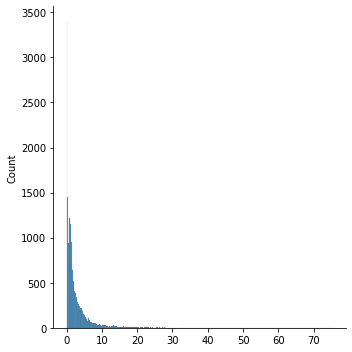

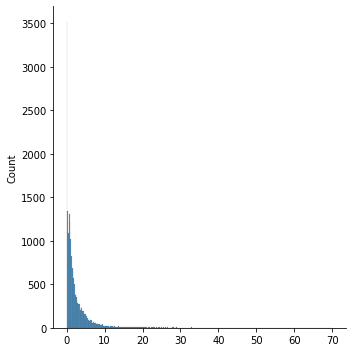

In [22]:
sns.displot(preds_nn[:, 1])
sns.displot(preds_lgb[:, 1])

In [23]:
preds_nn[0], preds_lgb[0]

(array([0.02120826, 5.6234956 , 0.03681415, 0.9671522 ], dtype=float32),
 array([0.02419203, 8.02964874, 0.02313256, 1.66414533]))